# OpenStreetMap Analysis Report

Date:27/09/2017 

**Author**: Mamadou Diallo

**Email:** mams.diallo@gmail.com

The project consists in the following files:

Source code for auditing and cleaning (separate files): '__*wrangle.py*__'

The .osm data set file '__*Nanterre.osm*__' is stored in compressed format here [Nanterre.osm.zip](https://github.com/mamsdiallo/DAND/blob/master/3.DataWrangling/Wrangle%20OpenStreetMap%20Data/Nanterre.osm.zip) 

The .osm Sample file which is part of the map region used: '__*sampleNanterre.osm*__'. It is stored in compressed format here [sampleNanterre.osm.zip](https://github.com/mamsdiallo/DAND/blob/master/3.DataWrangling/Wrangle%20OpenStreetMap%20Data/SampleNanterre.osm.zip)

File containing the list of references (Web sites, books, forums, blog posts, github repositories):
'__*References.txt*__'

## Data Wrangling Process
---

The process iterates through the following activities in that order.

__*1. GATHERING*__:

I choose the dataset located in Nanterre because I lived there for years before I moved to my current place.

Nanterre is located 5 km from Paris.

It has been extracted from Map Zen.

The bounding box is:
```
bounds {'minlat': '48.8688172', 
        'minlon': '2.1608126',
        'maxlat': '48.9260304',        
        'maxlon': '2.2435479'}
```
![Diagram](ExtractNanterreFrance2017-08-16_14-18.png)


__*2. CLEANING*__:

The following activities are conducted: 

a- Audit the data in terms of Validity, Accuracy, Completeness, Consistency and Uniformity

Script to launch, by first activating the environment:
```
activate DAND
python wrangle.py
```
b- Create a data cleaning plan
    - Identify Causes
    - Define Operations
    - Test

c- Execute the plan

d- Manual correct
    - use of dedicated tool
    - modification directly in the cvs files

__*3. Storing*__:

I choose SQL for completing the project. 

From cleaned csv files, it is stored in SQL format stored in a SQLite3 Database.

__*4. Analysis*__:

This document '__*Wrangle OpenStreetMap Data Notebook.ipynb*__' provides the analysis

__* Additional tooling*__:

Manual correction is tedious and we have the opportunity to use powerfull tools like: 

[OpenRefine](http://openrefine.org/)

## Process the Dataset
-----

### Issue: Header in cvs files

Sqlite Commands to import and error messages:
```
sqlite> .import nodes.csv nodes
nodes.csv:1: INSERT failed: datatype mismatch

sqlite> .import ways.csv ways
ways.csv:1: INSERT failed: datatype mismatch
```

Extract of source file node.csv
```
id,lat,lon,user,uid,version,changeset,timestamp
644169,48.9049071,2.1959349,osmmaker,210173,3,26474158,2014-11-01T02:01:56Z
644179,48.913021,2.1659623,Marcussacapuces91,37548,2,432639,2008-12-16T23:03:54Z
645164,48.9071846,2.1923733,jmorais,5404,1,191925,2007-01-11T18:35:03Z
```

#### Solution: 

Cutting all headers in csv files solved the problem. Since we have only 4 files, it was possible to do it manually.

### Issue: Encoding

Problematic tags in the dataset Nanterre.osm:
```XML
<tag k="addr:street" v="Allée René Descartes"/>
<tag k="addr:street" v="Place de l&#39;Hôtel de Ville"/>
<tag k="addr:street" v="Avenue du Château de Malmaison"/>
```

SQL COMMANDS
```sql
SELECT * FROM nodes_tags
WHERE type="addr" AND key="street"
LIMIT 3;
```

Here are some problematic results:

```sql
id|key|value|type
150856317|street|AllΘe RenΘ Descartes|addr
180968674|street|Place de l'H⌠tel de Ville|addr
275556597|street|Avenue du ChΓteau de Malmaison|addr
```

#### Solution: 

Change the code page to UTF-8 within powershell

Powershell command:

```
>chcp
Active code page: 850
>chcp 65001
Active code page: 65001
```

Change encoding to UTF-8 within sqlite with PRAGMA statement.

SQL command:
```sql
sqlite>PRAGMA encoding="UTF-8";
SELECT * FROM nodes_tags 
WHERE type="addr" AND key="street" 
LIMIT 3;
```

Here are the three results after changing parameters:
```sql
id|key|value|type
150856317|street|Allée René Descartes| addr
180968674|street|Place de l'Hôtel de Ville|addr
275556597|street|Avenue du Château de Malmaison|addr
```

### Issue: Variation in city names

```sql
SELECT key,value, COUNT(*) AS Nb FROM ways_tags
WHERE key='city'
GROUP BY value
ORDER BY value;
```

Result:

```sql
key|value|Nb
city|Bezons|7
city|Carrières-sur-Seine|4
city|Chatou|1
city|Colombes|2
city|Houilles|112
city|La Garenne-Colombes|3
city|Nanterre|1070
city|Puteaux|11
city|Rueil Malmaison|1
city|Rueil-Malmaison|16
city|Suresnes|2
```
Total Errors: 1 in ways_tags
Rueil Malmaison vs Rueil-Malmaison

```sql
SELECT key,value, COUNT(*) AS Nb FROM nodes_tags
WHERE key='city'
GROUP BY value
ORDER BY value;
```
Result:

```sql
key|value|Nb
city|Bezons|5
city|Carrières-sur-Seine|1
city|Chatou|4
city|Colombes|6
city|Courbevoie|16
city|Houilles|15
city|La Garenne Colombes|3
city|La Garenne-Colombes|4
city|NANTERRE|3
city|Nanterre|1266
city|Paris La Défense Cedex|1
city|Puteaux|98
city|RUEIL MALMAISON|2
city|Rueil-Malmaison|96
city|Suresnes|285
city|houilles|1
```
Total Errors: 4 in nodes_tags 

La Garenne Colombes vs La Garenne-Colombes

RUEIL MALMAISON vs Rueil-Malmaison

Houilles vs houilles

Nanterre vs NANTERRE

#### Solution:
The solution is based on post-processing operation from the two excel files (ways_tags and nodes_tags). Then, I apply mass correction - 1806 rows -  with OpenRefine from the clustering feature.

Here below, filtered elements for nodes_tags.csv with key='city'. We have for sure the same results and numbers for values:

![Diagram](CleanCityName01.jpg)

Use of the clustering feature (grouping and suggestion of merge done automatically) for mass correction:

![Diagram](CleanCityName02.jpg)


Result of merging:

![Diagram](CleanCityName03.jpg)

### Issue: variation with phone numbers

Phone numbers are not formated uniformly.

```sql
SELECT DISTINCT value FROM nodes_tags WHERE key='phone';
```

Some remarkable outputs:
```sql
value
3631
39.92
01.49.61.06.34
+33 1  41193500
+33 1 47 78 95 99
08.92.68.69.25
0147493186
01.46.69..06.17
09 54 58 67 66
```

We have phone numbers:

- with country code and space separator (e.g. +33 1 47 78 95 99)
- with country code and no separator (e.g. +33 1  41193500)
- without country code and space separator (e.g. 09 54 58 67 66)
- without country code and dot separator (e.g. 01.49.61.06.34)
- without country code and no separator (e.g. 0147493186)
- typos (e.g. 01.46.69..06.17)
- special numbers (e.g. 3631 or 39.92)

#### Solution:

I chose to use country code with space as separator for readability: +33 N NN NN NN NN

Where +33 is the French country code. There should be 9 digits after the country code

Exception: special numbers. I chose to not use country code. 
3631 => 3631 
39.92 => 3992


The code is the following:

```python
def update_phone(phone_num):
    import string
    whitelist = string.letters + string.digits + ' ' + '+'+';'
    new_s = ''
    for char in phone_num:
        if char == ' ':
            new_s += ''
        elif char in whitelist:
            new_s += char
        else:
            new_s += ''
    new_s = new_s.strip()
    if new_s[:4]=='0033':
        new_s = '+33'+new_s[4:]
    elif new_s[:1]=='0':
        new_s = '+33'+new_s[1:]
      
    # change format for readability
    if len(new_s) == 4:
        # special phone numbers
        phone_num_parts = []
        phone_num_parts.append(new_s)
        return ''.join(phone_num_parts) 
    else:
        # regular phone numbers
        phone_num_parts = []
        phone_num_parts.append(new_s[:3])
        phone_num_parts.append(' ')
        phone_num_parts.append(new_s[3:4])
        phone_num_parts.append(' ')
        phone_num_parts.append(new_s[4:6])
        phone_num_parts.append(' ')
        phone_num_parts.append(new_s[6:8])
        phone_num_parts.append(' ')
        phone_num_parts.append(new_s[8:10])
        phone_num_parts.append(' ')
        phone_num_parts.append(new_s[10:12])
        return ''.join(phone_num_parts)   
```

The remarkable examples become:
```sql
value
3631
3992
+33 1 49 61 06 34
+33 1 41 19 35 00
+33 1 47 78 95 99
+33 8 92 68 69 25
+33 1 47 49 31 86
+33 1 46 69 06 17
+33 9 54 58 67 66
```

The following code used within 'shape_element' function allows to process list of phone numbers separated by ';' delimiter:

```python
phone = data["value"]
lst = phone.split(';')
s = []
for item in lst:
    s.append(update_phone(item))

ph = ';'.join(s)
data["value"] = ph                    
```

Here is the transformation:
```
'01.47.21.14.27; 01.47.24.08.68' => '+33 1 47 21 14 27;+33 1 47 24 08 68'
```

### Issue: Street types

Do no confuse with next issue "Variation in street name"

In France, the street types are placed at the beginning.

Thus, we have to catch the first word.

The type of streets I met in Nanterre are the following:

```python
expected = [u'Aire', u'Allée', u'Avenue',u'Boulevard', u'Chemin', u'Cours', \
            u'Esplanade',u'Ile',u'Impasse',u'Jardins',u'Passage',u'Place',\
            u'Quai',u'Résidence', u'Route', u'Rue',u'Square', u'Terrasse']
```

#### Solution:

Audit street type code here:

```python
STREET_TYPE2_RE = re.compile(r'^\S+',re.IGNORECASE)

def audit_street_type(street_types, street_name):
    m = STREET_TYPE2_RE.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)
            
```

The correction of streets is given by the following mapping:

```python
mapping = { u'allée': u'Allée',
           u'avenue': u'Avenue',
           u'boulevard':u'Boulevard',
           u'cours':u'Cours',
           u'place':u'Place',
           u'Pl':u'Place',
           u'quai':u'Quai',
           u'rue': u'Rue',
           u'RUE': u'Rue',
           u'Residence':u'Résidence',
           u'terrasse':u'Terrasse'}
```

### Issue: Variation in street names

Do no confuse this issue with previous issue "street types"


Here are some street name request:

```sql
SELECT DISTINCT value FROM nodes_tags, 
    (SELECT id AS idd FROM nodes_tags WHERE key='street') as subquery 
WHERE id = idd AND key='street' 
ORDER BY value 
LIMIT 20;
```

----

Here are some interesting issues: 
>"Avenue Georges Clemenceau" vs "Avenue Georges Clémenceau": accent
>
>"Place de la Defense" vs "place de la Défense": accent and uppercase
>
> "Place du 8 Mai 1945" vs "Place du 8 mai 1945": uppercase or lowercase
> 
> "Rue Gabriel Peri" vs "Rue Gabriel Péri":accent
>
> "Rue Léon Maurice Nordmann" vs "Rue Léon-Maurice Nordmann": space instead of '-'
>
> "Rue Marceau" vs "Rue Marceau,": typo
>
> "Rue Noel Pons" vs "Rue Noël Pons": accent
>
> "Rue du 11 Novembre" vs "Rue du 11 Novembre 1918": 

#### Solution: 

Post-processing operation from excel files.

Make all street adresses into uppercase avoiding issues with "rue" and "Rue".

We could get rid of accent (e.g. é, è, à) but it is debatable. I chose to keep accents.

Use of OpenRefine tool for clustering and merge the same way I did for issue related to Variation in city names.

### Issue: variation in letters within housenumber

In France, we could have house number followed by a complement (e.g. bis,ter,quater, etc...)

We have the following variations:

```XML
<tag k="addr:housenumber" v="9 bis"/>
<tag k="addr:housenumber" v="47 Bis"/>
<tag k="addr:housenumber" v="7 B"/>
<tag k="addr:housenumber" v="2 ter; 2 quater"/>
<tag k="addr:housenumber" v="1bis"/>
<tag k="addr:housenumber" v="118Ter"/>
<tag k="addr:housenumber" v="18 T"/>
<tag k="addr:housenumber" v="10B"/>
<tag k="addr:housenumber" v="10T"/>
<tag k="addr:housenumber" v="99 A"/>
<tag k="addr:housenumber" v="48Q"/>
<tag k="addr:housenumber" v="6, 6 bis, 6 ter"/>
```

```sql
SELECT key,value FROM nodes_tags WHERE key='housenumber' AND value LIKE '%b%' LIMIT 50;
```
Here are some interesting outputs:
```sql
key|value
housenumber|9 bis
housenumber|47 Bis
housenumber|154 bis
housenumber|21 B
```

It is the same issue with ter, quart. And we have also list of housenumbers 

```sql
key|value
housenumber|17 Ter
housenumber|2 ter; 2 quater
```

#### Solution: 
We use code to audit and correct the issue.

We can create the following mapping based on the postal office recommendation:

NNN BIS, NNN Bis => NNN bis or NNN B (postal office recommendation). My decision: bis (lower case)

NNNBis,NNNbis => NNN bis or NNN B (postal office recommendation). My decision: NNN bis

TER, Ter => ter or T (postal office recommendation). My decision: ter 

NNNTer, NNNter => NNN ter or NNN T (postal office recommendation). My decision: NNN ter

QUAT, Quat, Quater, QUATER => quater or q (postal office recommendation). My decision: quater 

NNN Quater, NNN quater, NNN Quat => NNN quater or NNN Q (postal office reco). My decision: NNN quater

NNNQuater, NNNquater, NNNQuat => NNN quater or NNN Q (postal office reco). My decision: NNN quater

'Bâtiment B' should be kept as it is since 'Bâtiment' is not a number.

Here is the code:
```python
def update_housenb(nb, mapping):
    m = housenumber_re.search(nb)
    if m:
        complement = m.group(3)
        if complement in mapping:
            n = m.group(1)
            #print n+' '+mapping[complement]
            return n+' '+mapping[complement]
        else:
            return nb

    else:
        return nb
```

The following code used within 'shape_element' function allows to process list of house numbers separated by various delimiters:

```python
nb = data["value"]
lst = filter(None, re.split("[,;\-]+", nb))
s = []
for item in lst:
    s.append(update_housenb(item, bis_ter_quater))

better_nb = ';'.join(s)
data["value"] = better_nb                    
```

Here is the transformation:
```
'7-7 bis' => '7;7 bis'
```


### Issue: Empty values, leading and trailing space

Query trailing space (no leading space found): 
```sql
SELECT * FROM nodes_tags 
WHERE value LIKE '% ' 
LIMIT 10;
```
Here is the unique result:

```sql
id|key|value|type
4423855431|designation|Epicerie fine |regular
```
Query Trailing space for ways_tags table:

```sql
SELECT * FROM ways_tags
WHERE value LIKE '% '
LIMIT 10;
```
Unique result is:

```sql
id|key|value|type
295256565|description|Bibliothèque Universitaire Paris Nanterre Tél : 01 40 97 72 02 Maill : scd-bu@u-paris10.fr  Bibliothèque de Documentation Internationale Contemporaine Tel : 01 40 97 79 00 |regular
```

Query empty values:
```sql
SELECT * FROM nodes_tags WHERE value = '';
```

Here is the unique result:

```sql
id|key|value|type
4855994331|operator||regular
```

#### Solution: 

It is easy to audit and correct this type of issue directly in the code.

Here is the code for auditing:
```python
def empty_value(element, keys):
    # catch tags
    if element.tag == "tag":
        # get value
        str = element.get('v')
        if len(str.strip()) == 0:
            keys['empty'] += 1
        elif len(str.strip()) != len(str):
            keys['leading_trailing'] += 1
        else:
            keys['not_empty'] += 1
            
    return keys
```

## Explore the Database
---

### Preparation
- Create a database (OSM.db), 
- Access the database, 
- List all databases, 
- Import SQL3 file into SQLite, 
- Import CSV files (node.csv, nodes_tags.csv, ways.csv,ways_tags.csv,ways_nodes.csv) into a table (node)

From Powershell:
```
>.\sqlite3.exe OSM.db
```
From SQLite:
```sql
.databases
.read db.sql
.mode csv
.import nodes.csv nodes
.import nodes_tags.csv nodes
.import ways.csv nodes
.import ways_tags.csv nodes
.import ways_nodes.csv nodes
```

### Overview of the dataset

Is the OSM XML large enough?
```
$ ls -lh *Nanterre.osm*
-rw-r--r-- 1 Diallo 197609 107M août  20 16:54 Nanterre.osm
-rw-r--r-- 1 Diallo 197609  11M sept. 23 08:42 Nanterre.osm.zip
-rw-r--r-- 1 Diallo 197609  11M août  20 21:51 sampleNanterre.osm
-rw-r--r-- 1 Diallo 197609 1,3M sept. 23 08:56 sampleNanterre.osm.zip
```

It is conform to the minimum requirement of 50 MB uncompressed for the original OSM file and conform to the maximum requirement of 10 MB for the sample file.

### Description of the database
```sql
SELECT tbl_name, sql
FROM sqlite_master
WHERE type='table';
```

Output is:
```sql
nodes|CREATE TABLE nodes (
    id INTEGER PRIMARY KEY NOT NULL,
    lat REAL,
    lon REAL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT
)
nodes_tags|CREATE TABLE nodes_tags (
    id INTEGER,
    key TEXT,
    value TEXT,
    type TEXT,
    FOREIGN KEY (id) REFERENCES nodes(id)
)
ways|CREATE TABLE ways (
    id INTEGER PRIMARY KEY NOT NULL,
    user TEXT,
    uid INTEGER,
    version TEXT,
    changeset INTEGER,
    timestamp TEXT
)
ways_tags|CREATE TABLE ways_tags (
    id INTEGER NOT NULL,
    key TEXT NOT NULL,
    value TEXT NOT NULL,
    type TEXT,
    FOREIGN KEY (id) REFERENCES ways(id)
)
ways_nodes|CREATE TABLE ways_nodes (
    id INTEGER NOT NULL,
    node_id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    FOREIGN KEY (id) REFERENCES ways(id),
    FOREIGN KEY (node_id) REFERENCES nodes(id)
)
```

### Query on nodes_tags table: What the top 20 keys used?
```sql
SELECT key,COUNT(*) FROM nodes_tags
GROUP BY key
ORDER BY COUNT(*)
DESC
LIMIT 20;
```

Results:
```sql
key|COUNT(*)
source|13374
housenumber|5055
highway|4925
amenity|3688
name|2987
natural|2744
street|2110
city|1806
country|1602
postcode|1433
wheelchair|1253
tactile_paving|1097
barrier|951
type|934
operator|906
height|890
shop|846
bollard|779
entrance|756
public_transport|660
```


### Query on nodes_tags table: What are the top 10 sources of information?

Query: It is given by key = source

```sql
SELECT key,value,COUNT(*) AS Nb FROM nodes_tags
WHERE key='source'
GROUP BY value
ORDER BY Nb
DESC
LIMIT 10;
```

Results:

```sql
key|value|Nb
source|survey|1455
source|cadastre-dgi-fr source : Direction Générale des Impôts - Cadastre. Mise à jour : 2014|1428
source|survey 2014|863
source|cadastre-dgi-fr source : Direction Générale des Impôts - Cadastre. Mise à jour : 2010|792
source|survey 2016|767
source|cadastre 2016 + survey|704
source|opendata.paris.fr|614
source|survey 2015|521
source|Microsoft Bing orbital imagery + survey|417
source|cadastre-dgi-fr source : Direction Générale des Impôts - Cadastre. Mise à jour : 2012|386
```

### Query on ways_tags table: statistics of building heights

I use cast function to avoid issues with values that are string.
Issues: string ordering '90' > '110' and summary data like minimum and maximum. 

The query with cast function:
```sql
SELECT DISTINCT id, key, CAST(value AS FLOAT) AS height FROM ways_tags,
  (SELECT id AS idd FROM ways_tags WHERE key='building' ) AS sub
WHERE id=idd AND key='height'
ORDER BY height
```

Here are the 10 smallest heights:

```sql
id|key|height
47872151|height|1.0
71341167|height|1.0
71427150|height|1.0
71341236|height|1.5
71341248|height|1.5
71341262|height|1.5
71341312|height|1.5
109471844|height|2.0
109471847|height|2.0
71341265|height|3.0
```

Query to get the mean:
```sql
SELECT DISTINCT avg(CAST(value AS FLOAT)) AS mean_height FROM ways_tags, (SELECT id AS idd from ways_tags WHERE key='building' ) AS sub WHERE id=idd AND key='height';
```

Here is the mean:

```sql
mean_height
33.2682142857142
```

Query to get the minimum:
```sql
SELECT DISTINCT min(CAST(value AS FLOAT)) AS min_height FROM ways_tags, (SELECT id AS idd from ways_tags WHERE key='building' ) AS sub WHERE id=idd AND key='height';
```

Here is the minimum:

```sql
min_height
1.0
```
Query to get the maximum:
```sql
SELECT DISTINCT max(CAST(value AS FLOAT)) AS max_height FROM ways_tags, (SELECT id AS idd from ways_tags WHERE key='building' ) AS sub WHERE id=idd AND key='height';
```
Here is the minimum:
```sql
max_height
195.0
```

### Query on nodes table: histogram of activities 
```sql
.head on
.mode csv
.output sumNodesDaily.csv
SELECT DATE(timestamp) AS date FROM nodes ORDER BY timestamp;
.exit
```

In [21]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Get the Data and create the data frame
path = ''
filename = 'sumNodesDaily.csv'
nodes = pd.read_csv(path+filename)

nodes['date'] = pd.to_datetime(nodes['date'])

### Query on nodes table: 

In [22]:
import datetime as dt
import pandas as pd
nodes['Year']= nodes['date'].dt.year

In [23]:
nodes.head()

,date,Year
0,2007-01-11,2007
1,2007-01-11,2007
2,2007-01-11,2007
3,2007-01-11,2007
4,2007-01-11,2007


In [24]:
by_year=nodes.groupby("Year").size()
by_year.head(n=12)

Year
2007       172
2008       550
2009      1565
2010    251624
2011     96460
2012     24909
2013     20893
2014     26143
2015     14208
2016     25567
2017      5958
dtype: int64

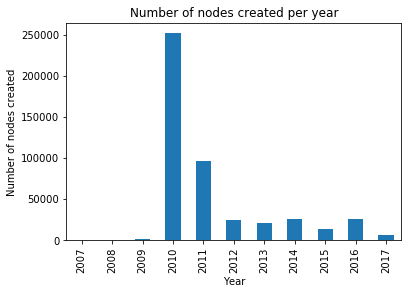

In [25]:
nodes.groupby("Year").size().plot(kind='bar')
plt.ylabel('Number of nodes created')
plt.xlabel('Year')
plt.title('Number of nodes created per year')
plt.show()

### Query on Dataset Statistics:

It should be consistent with the Tags extracted from the code in python

```
{'bounds': 1,
 'member': 12302,
 'nd': 639866,
 'node': 468049,
 'osm': 1,
 'relation': 938,
 'tag': 279545,
 'way': 75249}
```

Number of unique users
```sql
sqlite> SELECT COUNT(DISTINCT uid) AS nb_distinct_users FROM nodes;
```

Result:
```sql
nb_distinct_users
524
```

Number of nodes
```sql
SELECT COUNT(DISTINCT id) AS nb_nodes FROM nodes;
```

Result confirming the tags counting:
```sql
nb_nodes
468049
```

Number of ways:
```sql
SELECT COUNT(DISTINCT id) AS nb_ways FROM ways;
```

Result confirming the tags counting:
```sql
nb_ways
75249
```

Number of chosen type of nodes, like cafes, shops etc.

List of theatres:
```sql
SELECT key,value FROM nodes_tags, (SELECT id AS idd FROM nodes_tags where key='amenity' AND value='theatre') AS
subquery WHERE id=idd AND key='name';
```

Results:

```sql
key|value
name|Théâtre des Amandiers
name|Théatre par le bas
name|Théatre André Malraux
name|Bernard-Marie Koltès
```

List of motorways:

```sql
SELECT key,value FROM ways_tags, 
    (SELECT id AS idd FROM ways_tags WHERE key='highway' AND value ='motorway') AS sub 
WHERE id=idd AND key='ref' 
GROUP BY 2 
ORDER BY 2;
```

Here are the results: 

```sql
key|value
ref|A 14
ref|A 86
ref|N 1014
```

## Way forward

The valid street names in France could be found from here:
[reference](https://www.data.gouv.fr/en/datasets/fichier-fantoir-des-voies-et-lieux-dits/)

It could be interesting to use the refence to check the validity of the street names.

OSM France initiated an address centered project called "BANO" (Base d'Adresses Nationale Ouverte). This database is a composite from OSM address data, available opendata sets, cadastre data automatically extracted. The resulting composite dataset is available under ODbL license and can be used to improve OSM addresses and street names. For more detail see BANO project or http://openstreetmap.fr/bano.

What is done for phone could be easily done for Fax.

Here is the request:

```sql
SELECT key,value FROM nodes_tags
WHERE key='fax'
LIMIT 10;
```

Some results:

```sql
key|value
fax|01.47.21.81.21
fax|+33 1  41193515
fax|01.47.29.54.59
fax|01.41.37.52.53
fax|01.47.25.46.24
fax|+33 1 47 21 80 02
fax|01.47.08.24.47
fax|01.46.91.92.65
fax|01.47.21.29.33
fax|01.47.21.43.40
```

## Conclusion

Let's start with this citation:

A map is not the territory it represents, but, if correct, it has a similar structure to the territory, which accounts for its usefulness.

— Alfred Korzybski, Science and Sanity (1933, p. 58)

Another way to say it:

"All models are wrong but some are useful"

— George E. P. Box

Issues occurred with 2 tables out of 4. 

table|remarks
--|--
nodes|ok
nodes_tags|issues
ways|ok
ways_tags|issues
ways_nodes|ok

The processing and database construction depends on the country for streets names.
The types of street in France are very numerous (about 330).

It requires way more time to complete a comprehensive cleaning process. 

Using Mass correction with tools like OpenRefine is fast and efficient.